# Feature Importance (inspection)

In [20]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(diabetes.data, diabetes.target, random_state=0)
model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_val, y_val)

0.3566606238695452

In [22]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{diabetes.feature_names[i]:<8}"f"{r.importances_mean[i]:.3f}"f"+/-{r.importances_std[i]:.3f}")

s5      0.204+/-0.050
bmi     0.176+/-0.048
bp      0.088+/-0.033
sex     0.056+/-0.023


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [17]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy in test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy in test data: 0.97


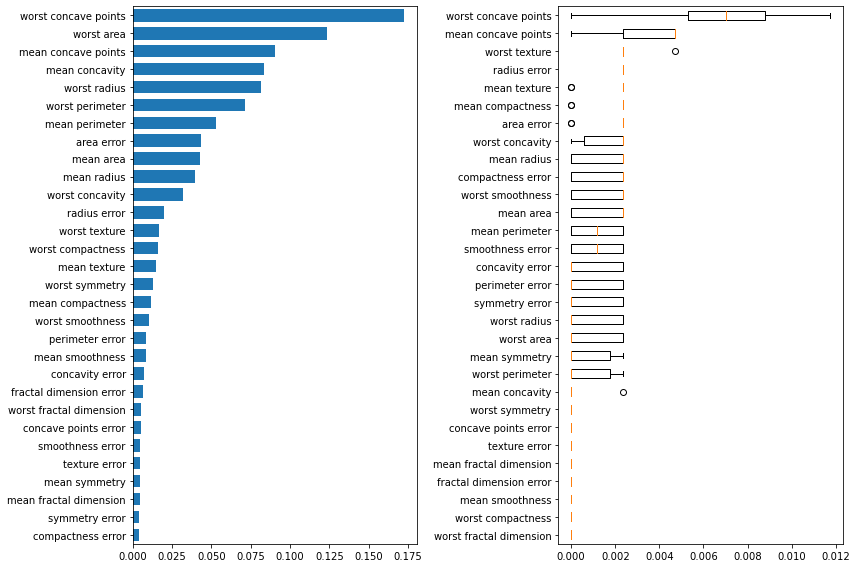

In [21]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
tree_importances_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importances_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

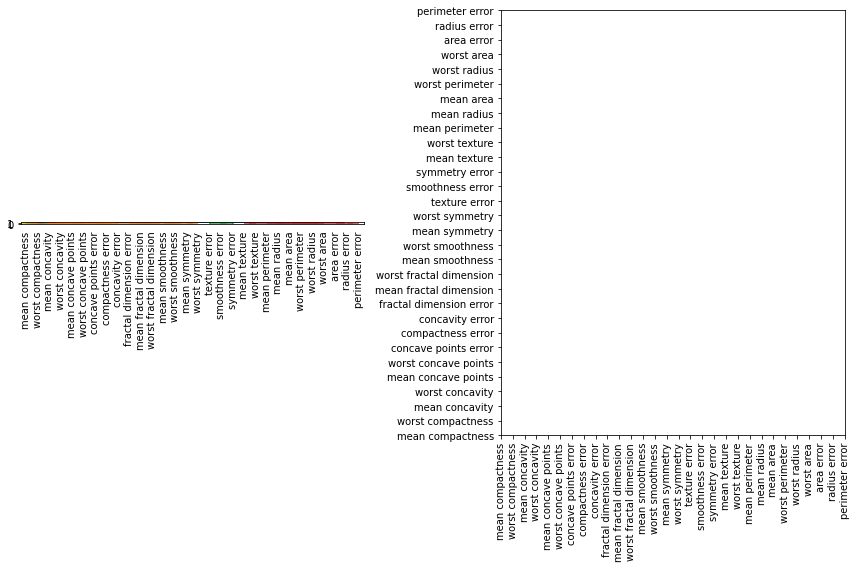

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation #gives correlation and p value
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax1.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [33]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97


# Visualizations

In [39]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X, y = fetch_openml(data_id=1464, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

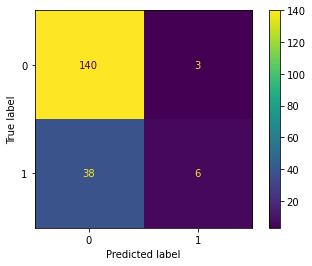

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

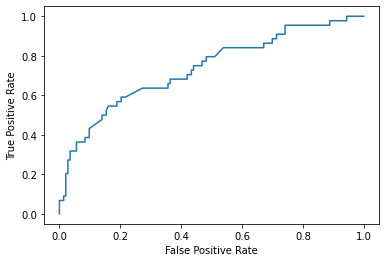

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = clf.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

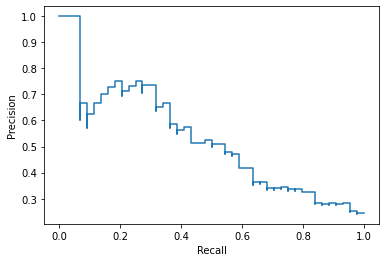

In [42]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

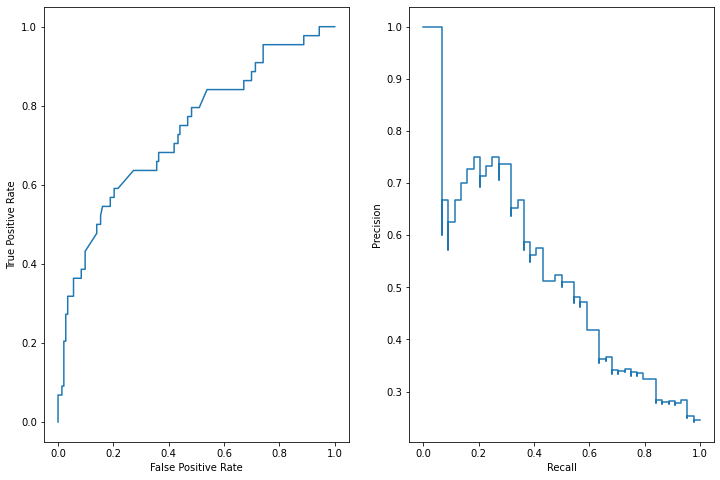

In [43]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

# Pipeline and composite estimators

## Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [("reduce_dim", PCA()), ("clf", SVC())]
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB())

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

In [4]:
print(pipe.steps[0])
print(pipe[0])
pipe['reduce_dim']

('reduce_dim', PCA())
PCA()


PCA()

In [5]:
pipe.named_steps.reduce_dim is pipe['reduce_dim']

True

In [6]:
print(pipe[:1])
pipe[-1:]

Pipeline(steps=[('reduce_dim', PCA())])


Pipeline(steps=[('clf', SVC())])

In [7]:
pipe.set_params(clf__C=10)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC(C=10))])

In [8]:
pipe.set_params(reduce_dim__n_components=2)

Pipeline(steps=[('reduce_dim', PCA(n_components=2)), ('clf', SVC(C=10))])

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(reduce_dim__n_components=[2, 5, 10], clf__C = [0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [10]:
from sklearn.linear_model import LogisticRegression
param_grid = dict(reduce_dim=['passthrough', PCA(5), PCA(10)], clf=[SVC(), LogisticRegression()], clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [11]:
pipe[0]

PCA(n_components=2)

In [12]:
pipe['reduce_dim']

PCA(n_components=2)

In [15]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
iris = load_iris()
pipe = Pipeline(steps=[('select', SelectKBest(k=2)), ('clf', LogisticRegression())])
print(pipe.fit(iris.data, iris.target))

Pipeline(steps=[('select', SelectKBest(k=2)), ('clf', LogisticRegression())])


c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of it

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


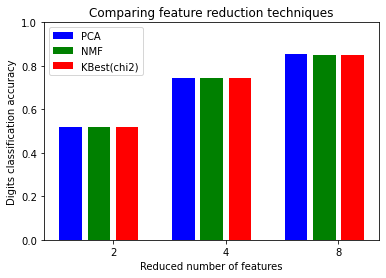

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
pipe = Pipeline([('reduce_dim', 'passthrough'), ('classify', LinearSVC(dual=False, max_iter=10000))])
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [{'reduce_dim': [PCA(iterated_power=7), NMF()],
              'reduce_dim__n_components':N_FEATURES_OPTIONS,
              'classify__C': C_OPTIONS},
             {
                 'reduce_dim':[SelectKBest(chi2)],
                 'reduce_dim__k':N_FEATURES_OPTIONS,
                 'classify__C':C_OPTIONS
             }]
reducer_labels = ["PCA", "NMF", 'KBest(chi2)']
grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
X, y = load_digits(return_X_y = True)
grid.fit(X, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + .5)
plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel("Reduced number of features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Digits classification accuracy")
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()

In [2]:
mean_scores

array([[0.5208403 , 0.74346951, 0.85534045],
       [0.5208403 , 0.74291396, 0.85088517],
       [0.5208403 , 0.74291396, 0.85144228]])

In [3]:
bar_offsets

array([0.5, 4.5, 8.5])

Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


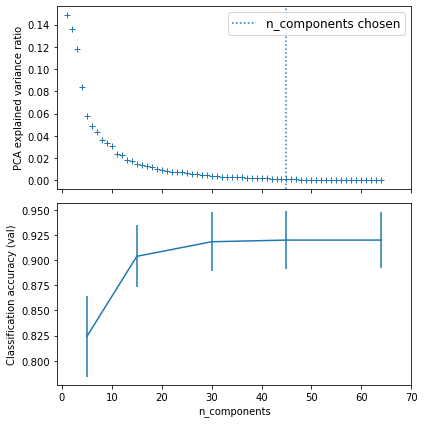

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
X_digits, y_digits = datasets.load_digits(return_X_y=True)
param_grid = {'pca__n_components': [5, 15, 30, 45, 64],
             'logistic__C': np.logspace(-4, 4, 4)}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):"%search.best_score_)
print(search.best_params_)
pca.fit(X_digits)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel("PCA explained variance ratio")
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clf = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))
best_clf.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.xlim(-1, 70)
plt.tight_layout()
plt.show()

In [10]:
best_clf

,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
param_pca__n_components,,,,,,,,,,,,,,,,
5,5,1.050391,0.118675,0.000000,0.000000,0.046416,5,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.838889,0.750,0.844011,0.869081,0.818942,0.824184,0.040388,17
15,6,0.705770,0.103057,0.000000,0.000000,0.046416,15,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.930556,0.850,0.924791,0.924791,0.888579,0.903743,0.030735,6
30,7,0.438210,0.051120,0.000000,0.000000,0.046416,30,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.922222,0.875,0.933148,0.961003,0.899721,0.918219,0.029255,3
45,8,0.506131,0.068873,0.003125,0.006249,0.046416,45,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.925000,0.875,0.941504,0.955432,0.902507,0.919889,0.028544,1
64,9,0.499882,0.053205,0.000000,0.000000,0.046416,64,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.925000,0.875,0.938719,0.955432,0.905292,0.919889,0.027828,1


In [15]:
from sklearn import set_config
set_config(display='diagram')
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_features=20, n_informative=3, n_redundant=0, n_classes=2, n_clusters_per_class=2, 
                           random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
annova_filter = SelectKBest(f_classif, k=3)
clf = LinearSVC()
annova_svm = make_pipeline(annova_filter, clf)
annova_svm.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = annova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.75      0.90      0.82        10

    accuracy                           0.84        25
   macro avg       0.84      0.85      0.84        25
weighted avg       0.85      0.84      0.84        25



In [16]:
annova_svm[-1].coef_

array([[0.7579098 , 0.27158923, 0.26109682]])

In [17]:
annova_svm[:-1].inverse_transform(annova_svm[-1].coef_)

array([[0.        , 0.        , 0.7579098 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.27158923,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.26109682]])

In [20]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
print(pipe)
rmtree(cachedir)

Pipeline(memory='C:\\Users\\jatin\\AppData\\Local\\Temp\\tmpwj0o70w6',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])


In [22]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
pca1 = PCA()
svm1 = SVC()
pipe = Pipeline([('reduce_dim', pca1), ('clf', svm1)])
print(pipe.fit(X_digits, y_digits))
print(pca1.components_)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])
[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00 -7.49400542e-16 -3.95195020e-17 ... -1.38777878e-16
   2.22044605e-16 -2.42861287e-16]
 [ 0.00000000e+00  2.77555756e-17  4.18120683e-17 ... -5.55111512e-17
   1.11022302e-16 -1.31838984e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


In [25]:
cachedir = mkdtemp()
pca2 = PCA()
svm2 = SVC()
cached_pipe = Pipeline([('reduce_dim', pca2), ('clf', svm2)], memory=cachedir)
print(cached_pipe.fit(X_digits, y_digits))
print(cached_pipe.named_steps['reduce_dim'].components_)
rmtree(cachedir)

Pipeline(memory='C:\\Users\\jatin\\AppData\\Local\\Temp\\tmpg74s6qdu',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])
[[-1.77484909e-19 -1.73094651e-02 -2.23428835e-01 ... -8.94184677e-02
  -3.65977111e-02 -1.14684954e-02]
 [ 3.27805401e-18 -1.01064569e-02 -4.90849204e-02 ...  1.76697117e-01
   1.94547053e-02 -6.69693895e-03]
 [-1.68358559e-18  1.83420720e-02  1.26475543e-01 ...  2.32084163e-01
   1.67026563e-01  3.48043832e-02]
 ...
 [ 0.00000000e+00 -7.49400542e-16 -3.95195020e-17 ... -1.38777878e-16
   2.22044605e-16 -2.42861287e-16]
 [ 0.00000000e+00  2.77555756e-17  4.18120683e-17 ... -5.55111512e-17
   1.11022302e-16 -1.31838984e-16]
 [ 1.00000000e+00 -1.68983002e-17  5.73338351e-18 ...  8.66631300e-18
  -1.57615962e-17  4.07058917e-18]]


## Transforming target in regression

In [31]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X, y = fetch_california_housing(return_X_y=True)
X, y = X[:2000, :], y[:2000]
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=regressor, transformer=transformer)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))
raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.61
R2 score: 0.59


In [32]:
def func(x):
    return np.log(x)
def inverse_func(x):
    return np.exp(x)

In [34]:
regr = TransformedTargetRegressor(regressor=regressor, func=func, inverse_func=inverse_func)
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.51


In [35]:
def inverse_func(x):
    return x
regr = TransformedTargetRegressor(regressor=regressor, func=func, inverse_func=inverse_func, check_inverse=False)
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: -1.57


## FeatureUnion: composite features spaces

In [4]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
ct = ColumnTransformer([("norm1", Normalizer(norm='l1'), [0, 1]), ("norm2", Normalizer(norm = 'l1'), slice(2, 4))])
X = np.array([[0, 1, 2, 2], [1, 1, 0, 1]])
ct.fit_transform(X)

array([[0. , 1. , 0.5, 0.5],
       [0.5, 0.5, 0. , 1. ]])

In [5]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, KernelPCA
estimators = [('linear_pca', PCA()), ("kernel_pca", KernelPCA())]
combined = FeatureUnion(estimators)
combined

FeatureUnion(transformer_list=[('linear_pca', PCA()),
                               ('kernel_pca', KernelPCA())])

In [6]:
combined.set_params(kernel_pca='drop')

FeatureUnion(transformer_list=[('linear_pca', PCA()), ('kernel_pca', 'drop')])

In [8]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1)), ("svd", TruncatedSVD(n_components=2))])
X = [[0, 1, 3], [2, 2, 5]]
union.fit_transform(X)

array([[ 1.5       ,  3.03954967,  0.87243213],
       [-1.5       ,  5.72586357, -0.46312679]])

In [9]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_union
make_union(PCA(), TruncatedSVD())

FeatureUnion(transformer_list=[('pca', PCA()),
                               ('truncatedsvd', TruncatedSVD())])

In [14]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
iris = load_iris()
X, y = iris.data, iris.target
pca = PCA(n_components=2)
selection = SelectKBest(k = 1)
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has ", X_features.shape[1], "features")
svm = SVC(kernel="linear")
pipeline = Pipeline([("features", combined_features), ("svm", svm)])
param_grid = dict(features__pca__n_components=[1, 2, 3], features__univ_select__k=[1, 2], svm__C=[0.1, 1, 10])
grid_search = GridSearchCV(pipeline, param_grid = param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Combined space has  3 features
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.867, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=1.000, total=   0.0s
[CV] fea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=10, score=0.900, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=10, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=10, score=1.000, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=0.933, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=0.967, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_compone

[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=1, score=0.967, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=1, svm__C=1 
[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=1, score=1.000, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=1, svm__C=1 
[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=1, score=0.933, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=1, svm__C=1 
[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=1, score=0.967, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=1, svm__C=1 
[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=1, score=1.000, total=   0.0s
[CV] features__pca__n_components=3, features__univ_select__k=1, svm__C=10 
[CV]  features__pca__n_components=3, features__univ_select__k=1, svm__C=10, score=1.000, total=   0.0s
[CV] features__p

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.1s finished


## Column Transformation for heterogeneous data

In [15]:
import pandas as pd
X = pd.DataFrame({
    "city": ["London", "Londom", "Paris", "Sallisaw"],
    "title": ["His Last Bow", "How Watson Learned the Trick", "A Moveable Feast", "The Grapes of Warth"],
    'expert_rating': [5, 3, 4, 5],
    'user_rating': [4, 5, 4, 3]
})

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
columns_trans = ColumnTransformer([('categories', OneHotEncoder(dtype='int'), ["city"]),
                                  ("title_bow", CountVectorizer(), 'title')], 
                                  remainder='drop')
print(columns_trans.fit(X))
columns_trans.transform(X).toarray()

ColumnTransformer(transformers=[('categories', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])


array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]], dtype=int64)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
ct = ColumnTransformer([
    ('scale', StandardScaler(),make_column_selector(dtype_include=np.number)),
    ('onehot', OneHotEncoder(), make_column_selector(pattern="city", dtype_include=object))
])
ct.fit_transform(X)

array([[ 0.90453403,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [-1.50755672,  1.41421356,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.30151134,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.90453403, -1.41421356,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [27]:
column_trans = ColumnTransformer([('city_category', OneHotEncoder(dtype='int'), ['city']),
                                 ('title_bow', CountVectorizer(), 'title')], remainder='passthrough')
column_trans.fit_transform(X)

array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 3, 5],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 5, 3]],
      dtype=int64)

In [29]:
from sklearn.preprocessing import MinMaxScaler
column_trans = ColumnTransformer([('city_category', OneHotEncoder(), ['city']),
                                 ('title_bow', CountVectorizer(), 'title')], remainder=MinMaxScaler())
column_trans.fit_transform(X)[:, -2:]

array([[1. , 0.5],
       [0. , 1. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [30]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer((OneHotEncoder(), ['city']),
                                      (CountVectorizer(), 'title'), remainder=MinMaxScaler())
column_trans

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

## Set Config

In [37]:
from sklearn import set_config
set_config(display='diagram')
column_trans
#use to display pipeline diagram

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

In [39]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC

In [40]:
categories = ['sci.med', 'sci.space']
X_train, y_train = fetch_20newsgroups(random_state=1, subset='train', categories=categories, remove=('footers', 'quotes'),
                                     return_X_y = True)
X_test, y_test = fetch_20newsgroups(random_state=1, subset='test', categories=categories, remove=('footers', 'quotes'),
                                   return_X_y=True)
print(X_train[0])

From: mccall@mksol.dseg.ti.com (fred j mccall 575-3539)
Subject: Re: Metric vs English
Article-I.D.: mksol.1993Apr6.131900.8407
Organization: Texas Instruments Inc
Lines: 31




American, perhaps, but nothing military about it.  I learned (mostly)
slugs when we talked English units in high school physics and while
the teacher was an ex-Navy fighter jock the book certainly wasn't
produced by the military.

[Poundals were just too flinking small and made the math come out
funny; sort of the same reason proponents of SI give for using that.] 

-- 
"Insisting on perfect safety is for people who don't have the balls to live
 in the real world."   -- Mary Shafer, NASA Ames Dryden


In [41]:
def subject_body_extractor(posts):
    # construct object dtype array with two columns
    # first column = 'subject' and second column = 'body'
    features = np.empty(shape=(len(posts), 2), dtype=object)
    for i, text in enumerate(posts):
        # temporary variable `_` stores '\n\n'
        headers, _, body = text.partition('\n\n')
        # store body text in second column
        features[i, 1] = body

        prefix = 'Subject:'
        sub = ''
        # save text after 'Subject:' in first column
        for line in headers.split('\n'):
            if line.startswith(prefix):
                sub = line[len(prefix):]
                break
        features[i, 0] = sub

    return features


subject_body_transformer = FunctionTransformer(subject_body_extractor)

In [42]:
def text_stats(posts):
    return [{'length': len(text),
             'num_sentences': text.count('.')}
            for text in posts]


text_stats_transformer = FunctionTransformer(text_stats)

In [43]:
pipeline = Pipeline([
    # Extract subject & body
    ('subjectbody', subject_body_transformer),
    # Use ColumnTransformer to combine the subject and body features
    ('union', ColumnTransformer(
        [
            # bag-of-words for subject (col 0)
            ('subject', TfidfVectorizer(min_df=50), 0),
            # bag-of-words with decomposition for body (col 1)
            ('body_bow', Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ]), 1),
            # Pipeline for pulling text stats from post's body
            ('body_stats', Pipeline([
                ('stats', text_stats_transformer),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]), 1),
        ],
        # weight above ColumnTransformer features
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        }
    )),
    # Use a SVC classifier on the combined features
    ('svc', LinearSVC(dual=False)),
], verbose=True)

In [44]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Classification report:\n\n{}'.format(
    classification_report(y_test, y_pred))
)

[Pipeline] ....... (step 1 of 3) Processing subjectbody, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total=   2.1s
[Pipeline] ............... (step 3 of 3) Processing svc, total=   0.1s
Classification report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       396
           1       0.86      0.84      0.85       394

    accuracy                           0.85       790
   macro avg       0.85      0.85      0.85       790
weighted avg       0.85      0.85      0.85       790



# Feature Extraction

## Dict Vectorizer

In [1]:
measurements = [
    {'city': 'Dubai', 'temperature':33,},
    {'city': 'London', 'temperature': 12},
    {'city': 'San Francisco', 'temperature':18}
    ]
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec.fit_transform(measurements).toarray()

array([[ 1.,  0.,  0., 33.],
       [ 0.,  1.,  0., 12.],
       [ 0.,  0.,  1., 18.]])

In [3]:
vec.get_feature_names()

['city=Dubai', 'city=London', 'city=San Francisco', 'temperature']

In [4]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz':1}]
X = v.fit_transform(D)
X

array([[2., 0., 1.],
       [0., 1., 3.]])

In [5]:
v.inverse_transform(X) == [{'bar': 2.0, 'foo':1.0},
                          {'baz':1.0, 'foo': 3.0}]

True

In [6]:
v.transform({'foo': 4, 'unseen_feature': 3})

array([[0., 0., 4.]])

In [14]:
movie_entry = [{'category': 'thriller', 'year':2003},
              {'category': 'animation', 'year':2011},
              {'year':1974}]
vec = DictVectorizer()
vec.fit_transform(movie_entry).toarray()

array([[0.000e+00, 1.000e+00, 2.003e+03],
       [1.000e+00, 0.000e+00, 2.011e+03],
       [0.000e+00, 0.000e+00, 1.974e+03]])

In [15]:
vec.get_feature_names()

['category=animation', 'category=thriller', 'year']

In [19]:
vec.transform({'category': ['thriller', 'drama'], 'unseen_feature':'3'}).toarray()

array([[0., 0., 0.]])

In [20]:
pos_window = [
    {
        'word-2': 'the',
        'pos-2': 'DT',
        'word-1':'cat',
        'pos-1':'NN',
        'word+1':'on',
        'pos+1': 'pp',
    },
]

In [21]:
vec = DictVectorizer()
pos_vectorized = vec.fit_transform(pos_window)
pos_vectorized

<1x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [22]:
pos_vectorized.toarray()

array([[1., 1., 1., 1., 1., 1.]])

In [23]:
vec.get_feature_names()

['pos+1=pp', 'pos-1=NN', 'pos-2=DT', 'word+1=on', 'word-1=cat', 'word-2=the']

## Feature Hasher

In [24]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10)
D = [{'dog':1, 'cat':2, 'elephant':4}, {'dog':2, 'run':5}]
f = h.transform(D)
f.toarray()

array([[ 0.,  0., -4., -1.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0., -2., -5.,  0.,  0.,  0.,  0.,  0.]])

## Text feature extraction

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    "This is the first document.",
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [30]:
print(X.toarray())

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [32]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()

['and this',
 'document is',
 'first document',
 'is the',
 'is this',
 'second document',
 'the first',
 'the second',
 'the third',
 'third one',
 'this document',
 'this is',
 'this the']

In [33]:
print(X2.toarray())

[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [36]:
analyzer = vectorizer.build_analyzer()
analyzer("This is a text document to analyze.") == (['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [40]:
vectorizer2.transform(["Something completely new."]).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [42]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern = r'\bw+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze("Bi-grams are cool!") == (["bi", 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

False

In [45]:
feature_index = vectorizer2.vocabulary_.get('is this')
X2[:, feature_index].toarray()

array([[0],
       [0],
       [0],
       [1]], dtype=int64)

### TfidfTransformer and TfidfVectorizer

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
corpus = [
    "This is the first document.",
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document'
]
vocabulary = ['this', 'document', 'and', 'one']
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)), 
                ('tfidf', TfidfTransformer())]).fit(corpus)
pipe['count'].transform(corpus).toarray()

array([[1, 1, 0, 0],
       [1, 2, 0, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0]], dtype=int64)

In [53]:
pipe['tfidf'].idf_

array([1.        , 1.22314355, 1.91629073, 1.91629073])

In [54]:
pipe.transform(corpus).shape

(4, 4)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [56]:
print(X.shape)

(4, 9)


In [57]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [58]:
counts = [[3, 0, 1],
         [2, 0, 0],
         [3, 0, 0],
         [4, 0, 0],
         [3, 2, 0],
         [3, 0, 2]]
tfidf = transformer.fit_transform(counts)
tfidf

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [59]:
tfidf.toarray()

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

In [61]:
transformer = TfidfTransformer()
transformer.fit_transform(counts).toarray()

array([[0.85151335, 0.        , 0.52433293],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.55422893, 0.83236428, 0.        ],
       [0.63035731, 0.        , 0.77630514]])

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

## decoding The Text

In [6]:
import chardet
text1 = b"Sei mir gegr\xc3\xbc\xc3\x9ft main Seuerkraut"
text2 = b"holdselig sind deine Ger \xfcche"
# text3 = b"\xff\xfeA\x00u\x00f\x00 \x00F\x001\x00\xfx\x00g\x00e\x001\x00n\x00 \x00d\x00e\x00s\x00 \x00G\x00e\x00s\x00a\x00n\x00g\x00e\x00s\x00, \x00 \x00H\x00e\x00r\x00z\x001\x00i\x00e\x00b\x00c\x00h\x00e\x00n\x00, \x00 \x00t\x00r\x00a\x00g\x00 \x00d\x00i\x00c\x00h\x00 \x00f\x00o\x00r\x00t\x00"
decoded = [x.decode(chardet.detect(x)['encoding']) for x in (text1, text2)]
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer().fit(decoded).vocabulary_
for term in v: print(v)

{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir': 5, 'gegrüßt': 1, 'main': 4, 'seuerkraut': 7, 'holdselig': 3, 'sind': 8, 'deine': 0, 'ger': 2, 'üche': 9}
{'sei': 6, 'mir'

In [7]:
import chardet    
text1 = b"Sei mir gegr\xc3\xbc\xc3\x9ft mein Sauerkraut"
text2 = b"holdselig sind deine Ger\xfcche"
text3 = b"\xff\xfeA\x00u\x00f\x00 \x00F\x00l\x00\xfc\x00g\x00e\x00l\x00n\x00 \x00d\x00e\x00s\x00 \x00G\x00e\x00s\x00a\x00n\x00g\x00e\x00s\x00,\x00 \x00H\x00e\x00r\x00z\x00l\x00i\x00e\x00b\x00c\x00h\x00e\x00n\x00,\x00 \x00t\x00r\x00a\x00g\x00 \x00i\x00c\x00h\x00 \x00d\x00i\x00c\x00h\x00 \x00f\x00o\x00r\x00t\x00"
decoded = [x.decode(chardet.detect(x)['encoding']) for x in (text1, text2, text3)]        
v = CountVectorizer().fit(decoded).vocabulary_    
for term in v: print(v) 

{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut

In [8]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [10]:
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        feature_names = feature_names[ch2.get_support()]
    print("done in %fs" % (time() - t0))
    print()


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 2.070392s at 1.922MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 1.290632s at 2.222MB/s
n_samples: 1353, n_features: 33809



In [11]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.629s
test time:  0.000s
accuracy:   0.897
dimensionality: 33809
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.050s
test time:  0.016s
accuracy:   0.888
dimensionality: 33809
density: 0.255302


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.065s
test time:  0.016s
accuracy:   0.898
dimensionality: 33809
density: 0.707977


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.016s
test time:  0.505s
accuracy:   0.858

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 4.016s
test time:  0.238s
accuracy:   0.837

L2 penalty
______________________________________

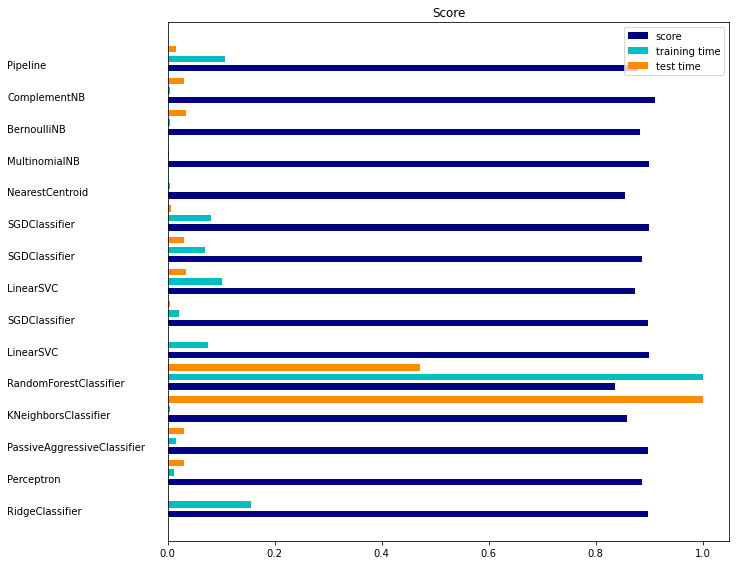

In [12]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 3.493451s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_siz

Loading dataset...
done in 4.071s.
Extracting tf-idf features for NMF...
done in 1.175s.
Extracting tf features for LDA...
done in 1.148s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.601s.


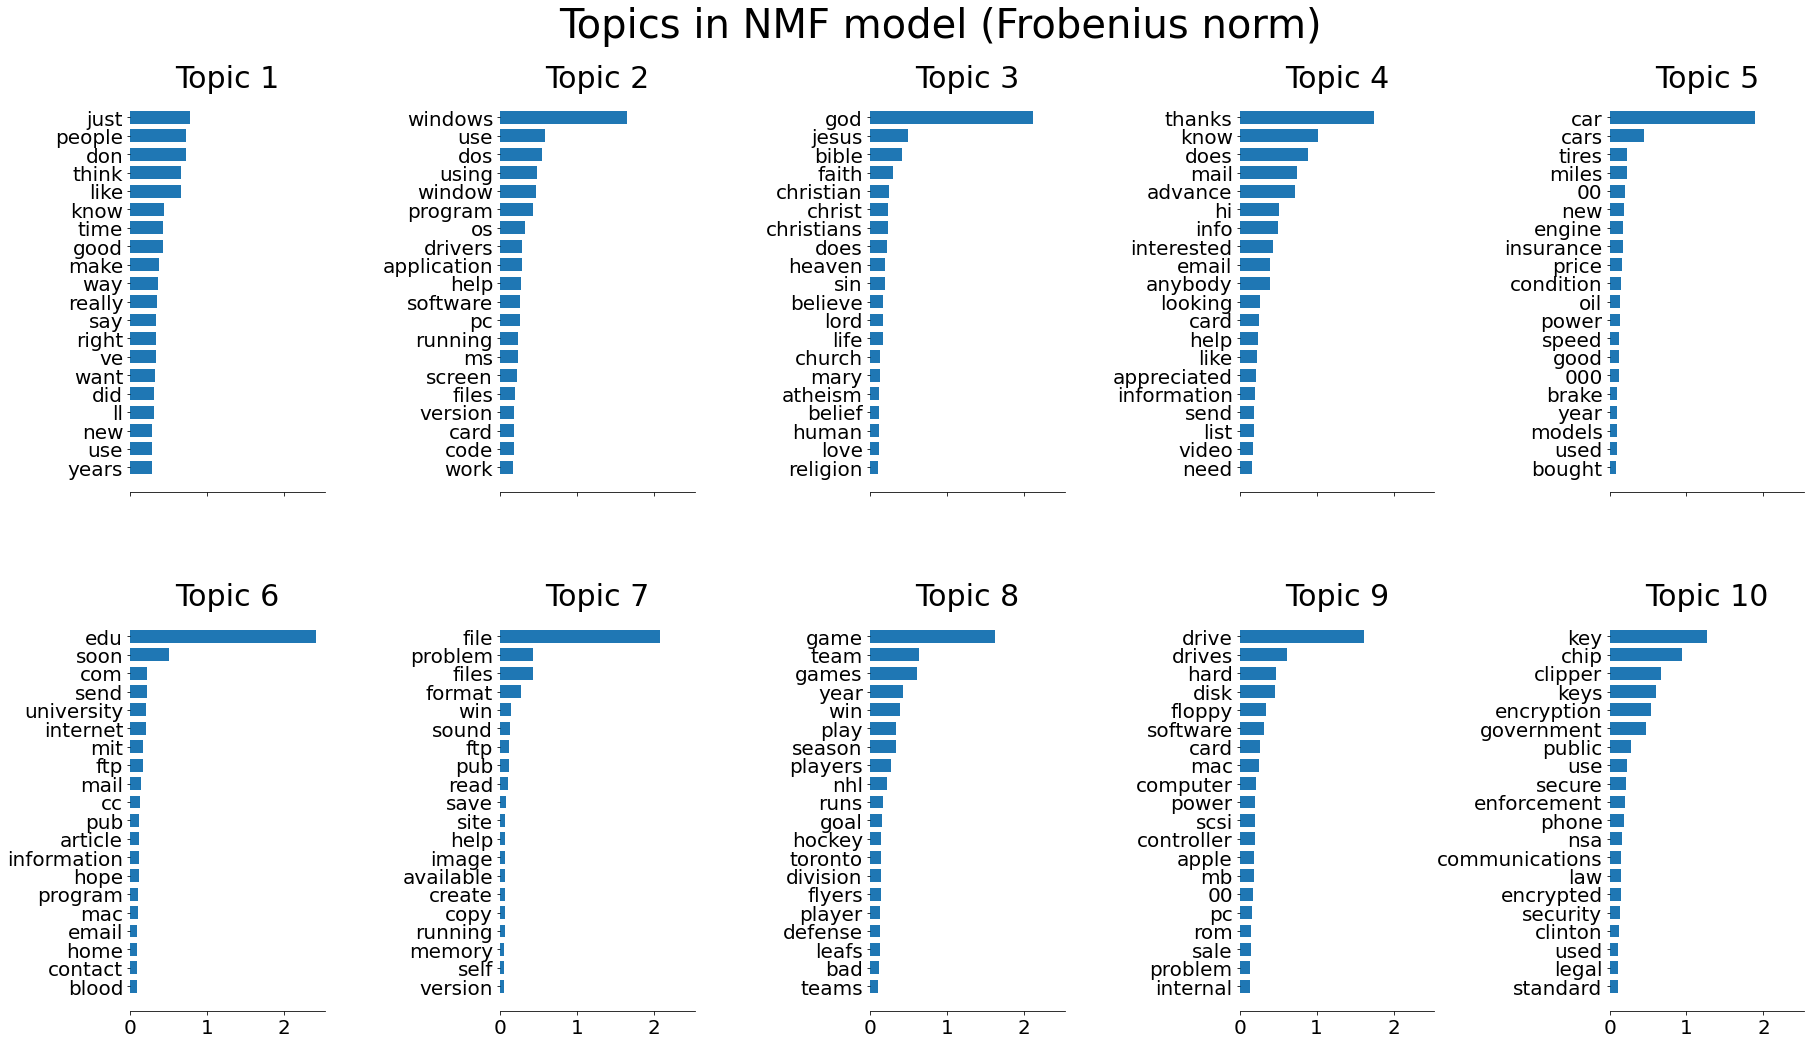



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 2.241s.


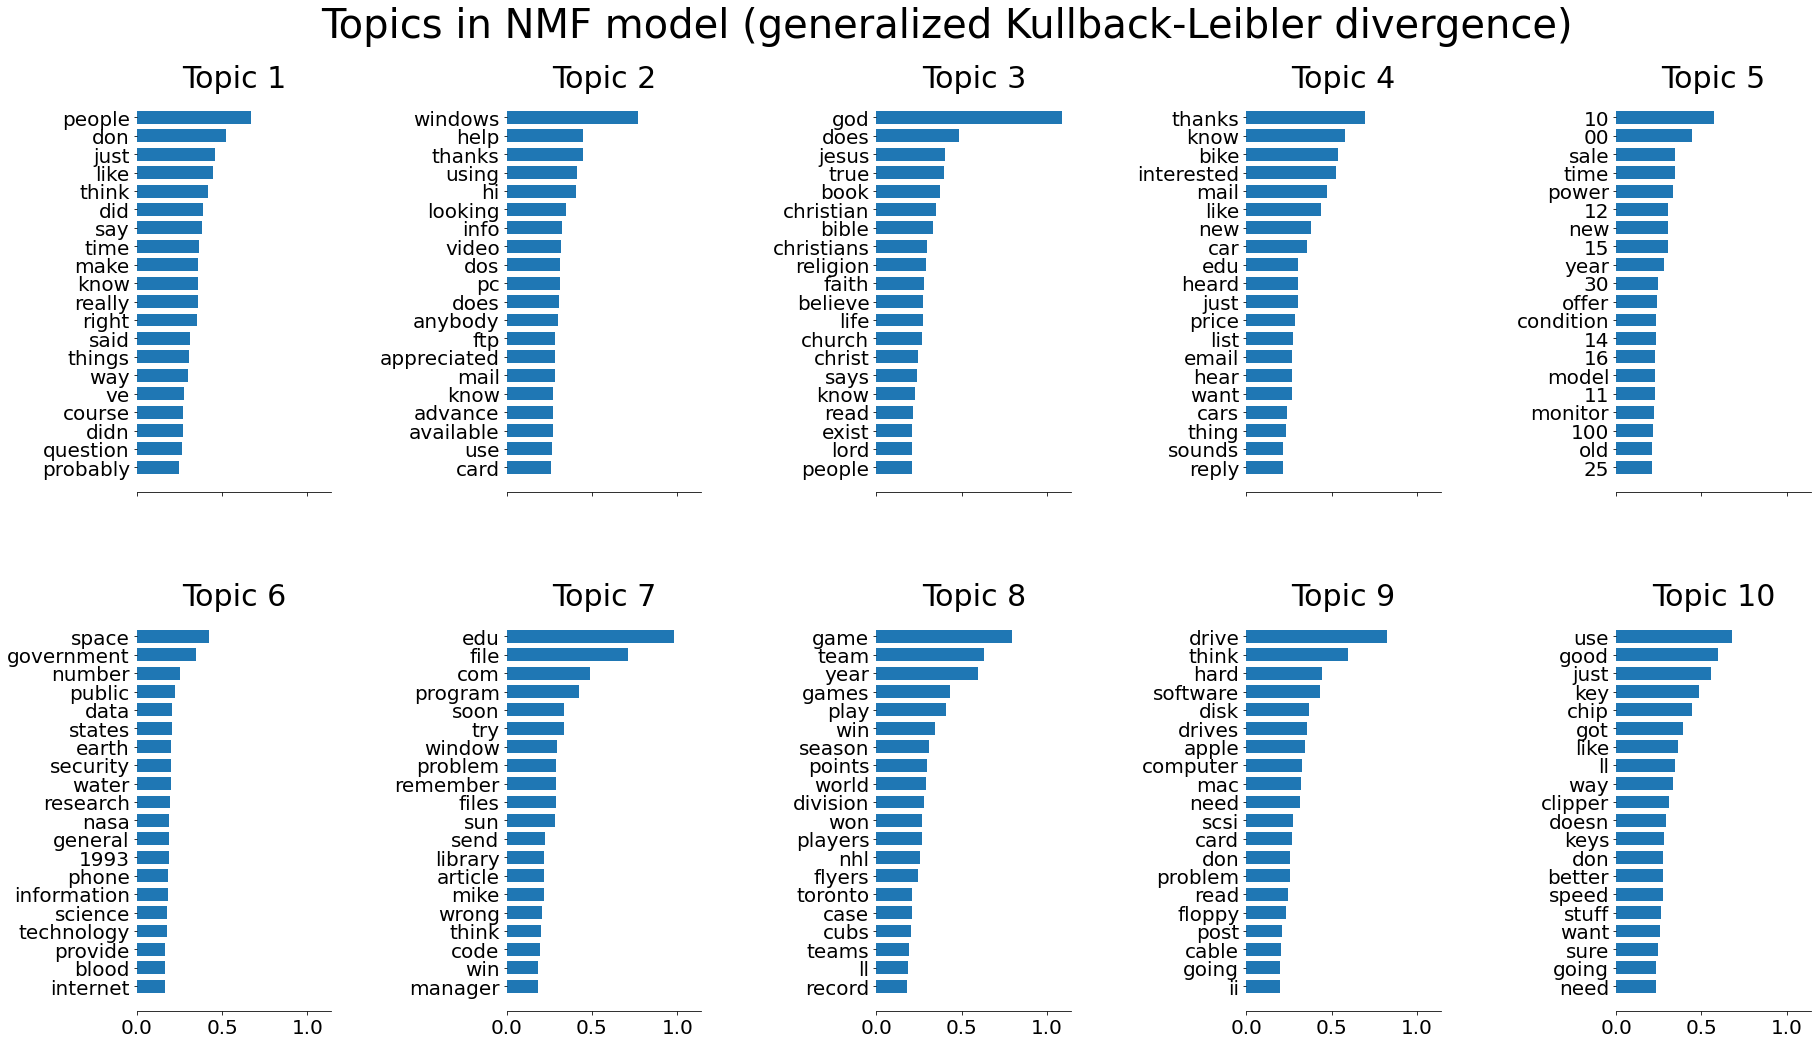



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 8.548s.


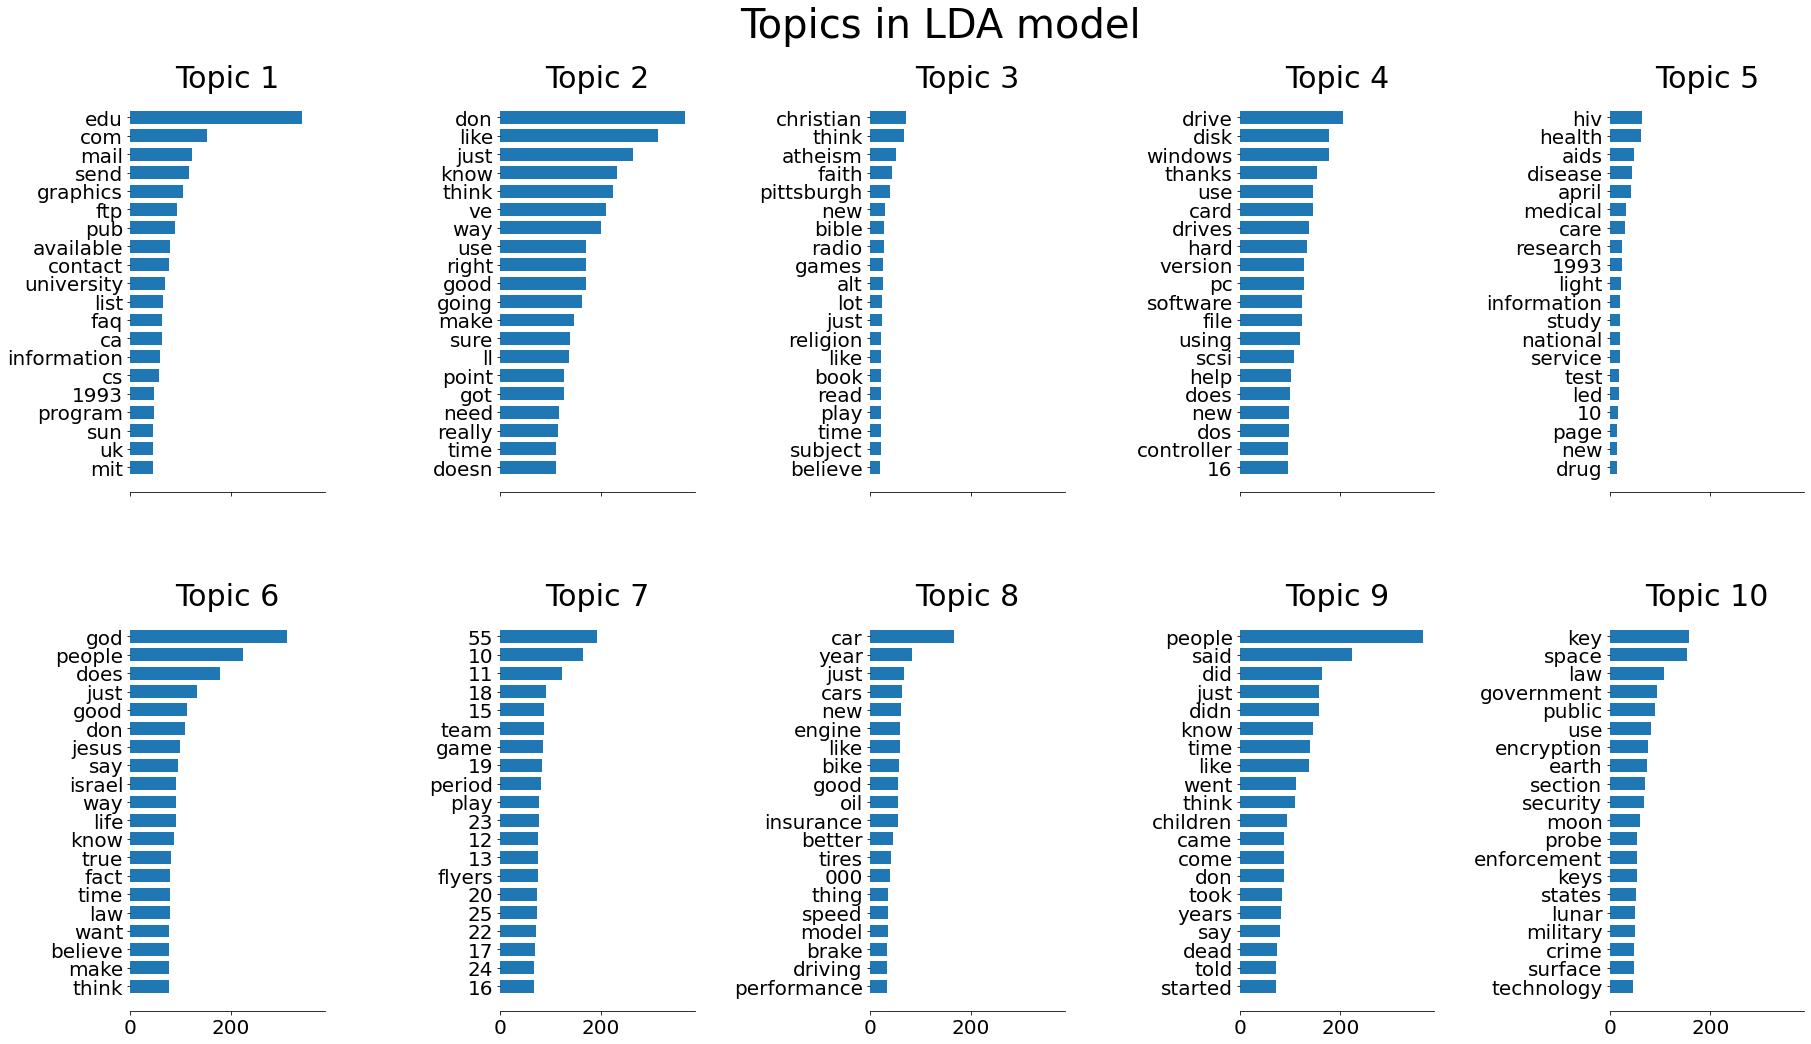

In [18]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [20]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
counts = ngram_vectorizer.fit_transform(['words', 'wprds'])
ngram_vectorizer.get_feature_names()

[' w', 'ds', 'or', 'pr', 'rd', 's ', 'wo', 'wp']

In [21]:
counts.toarray().astype(int)

array([[1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1]])

In [23]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
ngram_vectorizer.fit_transform(['jumpy fox'])

<1x4 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [24]:
ngram_vectorizer.get_feature_names()

[' fox ', ' jump', 'jumpy', 'umpy ']

In [25]:
ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(5, 5))
ngram_vectorizer.fit_transform(['jumpy fox'])

<1x5 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [27]:
ngram_vectorizer.get_feature_names()

['jumpy', 'mpy f', 'py fo', 'umpy ', 'y fox']

## Hashing Vectorizer

In [30]:
from sklearn.feature_extraction.text import HashingVectorizer
corpus = [
    "This is the first document.",
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document'
]
hv = HashingVectorizer(n_features=10)
hv.transform(corpus)

<4x10 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [31]:
hv = HashingVectorizer()
hv.transform(corpus)

<4x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [32]:
vectorizer = HashingVectorizer(n_features=2**4)
X = vectorizer.fit_transform(corpus)
print(X.shape)

(4, 16)


## Customizing the vectorizer classes

In [36]:
def my_tokenizer(s):
    return s.split()
vectorizer = CountVectorizer(tokenizer=my_tokenizer)
vectorizer.build_analyzer()(u"Some... punctuation!") == (['Some...', 'punctuation!'])

False

In [38]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
vect = CountVectorizer(tokenizer=LemmaTokenizer())

In [39]:
import re
def to_british(tokens):
    for t in tokens:
        t = re.sub(r"(...)our$", r"\1or", t)
        t = re.sub(r"([bt])re$", r"\1er", t)
        t = re.sub(r"([iy])s(e$|ing|ation)", r"\1z\2", t)
        t = re.sub(r"ogue$", "og", t)
        yield t

class CustomVectorizer(CountVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(to_british(tokenize(doc)))
print(CustomVectorizer().build_analyzer()(u"color colour"))        

['color', 'color']


## Image feature extraction

In [1]:
import numpy as np
from sklearn.feature_extraction import image
one_image = np.arange(4 * 4 * 3).reshape((4, 4, 3))
one_image[:, :, 0]

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45]])

In [2]:
patches = image.extract_patches_2d(one_image, (2, 2), max_patches=2, random_state=0)
patches.shape

(2, 2, 2, 3)

In [3]:
patches[:, :, :, 0]

array([[[ 0,  3],
        [12, 15]],

       [[15, 18],
        [27, 30]]])

In [4]:
patches = image.extract_patches_2d(one_image, (2, 2))

In [5]:
patches.shape

(9, 2, 2, 3)

In [6]:
patches[4, :, :, 0]

array([[15, 18],
       [27, 30]])

In [7]:
reconstructed = image.reconstruct_from_patches_2d(patches, (4, 4, 3))
np.testing.assert_array_equal(one_image, reconstructed)

In [8]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
one_image = load_sample_image("china.jpg")
print('Image shape: {}'.format(one_image.shape))
patches = image.extract_patches_2d(one_image, (2, 2))
print('Patches shape: {}'.format(patches.shape))
print(patches[1])
print(patches[800])

Image shape: (427, 640, 3)
Patches shape: (272214, 2, 2, 3)
[[[174 201 231]
  [174 201 231]]

 [[173 200 230]
  [173 200 230]]]
[[[187 214 243]
  [188 215 244]]

 [[187 214 243]
  [188 215 244]]]


In [9]:
from sklearn.datasets import load_sample_images
from sklearn.feature_extraction import image
X = load_sample_images().images[1]
print('Image shape: {}'.format(X.shape))
pe = image.PatchExtractor(patch_size=(2, 2))
pe_fit = pe.fit(X)
pe_trans = pe.transform(X)
print('Patches shape: {}'.format(pe_trans.shape))

Image shape: (427, 640, 3)
Patches shape: (545706, 2, 2)


Compute structured hierarchical clustering...
Elapsed time:  0.1955728530883789
Number of pixels:  4697
Number of clusters:  27


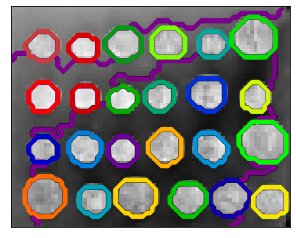

In [10]:
import time as time

import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version

# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version('0.14'):
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

# #############################################################################
# Generate data
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect",
                         **rescale_params)

X = np.reshape(rescaled_coins, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_coins.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

# Simple Imputer 

In [13]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  3.5,  9. ]])

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


In [16]:
import scipy.sparse as sp
X = sp.csc_matrix([[1, 2], [0, -1], [8, 4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)
X_test = sp.csc_matrix([[-1, 2], [6, -1], [7, 6]])
print(imp.transform(X_test).toarray())

[[3. 2.]
 [6. 3.]
 [7. 6.]]


In [17]:
import pandas as pd
df = pd.DataFrame([['a', 'x'], [np.nan, 'y'], ['a', np.nan], ['b', 'y']], dtype="category")
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


# Multivariate feature (Iterative Imputer)

In [19]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

array([[ 6.95847623,  2.        ,  3.        ],
       [ 4.        ,  2.6000004 ,  6.        ],
       [10.        ,  4.99999933,  9.        ]])

In [21]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
print(np.round(imp.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criteri

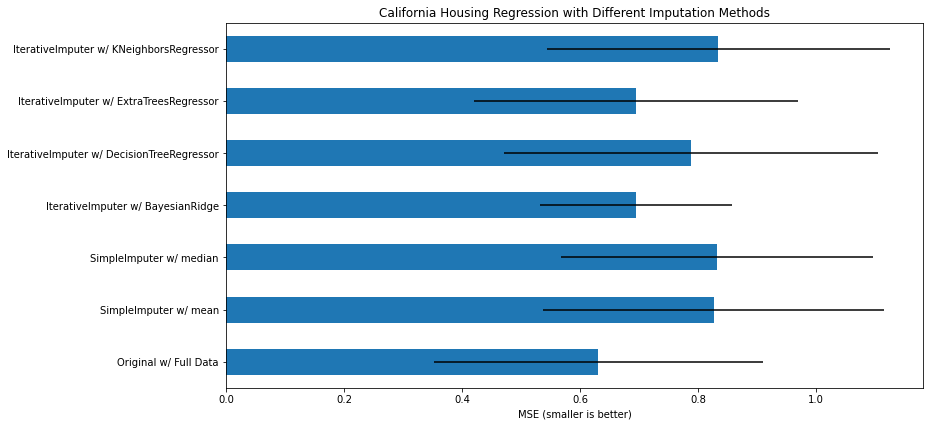

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

# Nearest neighbors imputation (KNN Imputer)

In [23]:
import numpy as np
from sklearn.impute import KNNImputer
X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors = 2)
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

In [24]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights='uniform')
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

# Missing Indicator

In [25]:
import numpy as np
from sklearn.impute import MissingIndicator
X1 = np.array([[np.nan, 1, 3], [4, 0, np.nan], [8, 1, 0]])
X2 = np.array([[5, 1, np.nan], [np.nan, 2, 3], [2, 4, 0]])
indicator = MissingIndicator()
indicator.fit(X1)
X2_tr = indicator.transform(X2)
X2_tr

array([[False,  True],
       [ True, False],
       [False, False]])

In [27]:
from sklearn.impute import MissingIndicator
X = np.array([[-1, -1, 1, 3], [4, -1, 0, -1], [8, -1, 1, 0]])
indicator = MissingIndicator(missing_values=-1)
mask_missing_values_only = indicator.fit_transform(X)
mask_missing_values_only

array([[ True,  True, False],
       [False,  True,  True],
       [False,  True, False]])

In [28]:
indicator.features_

array([0, 1, 3], dtype=int32)

In [29]:
indicator = MissingIndicator(missing_values=-1, features="all")
mask_all = indicator.fit_transform(X)
mask_all

array([[ True,  True, False, False],
       [False,  True, False,  True],
       [False,  True, False, False]])

In [30]:
indicator.features_

array([0, 1, 2, 3])

In [32]:
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
X, y = load_iris(return_X_y=True)
mask = np.random.randint(0, 2, size = X.shape).astype(bool)
X[mask] = np.nan
X_train, X_test, y_train, _ = train_test_split(X, y, test_size=100, random_state=0)

In [33]:
transformer = FeatureUnion(transformer_list=[("features", SimpleImputer(strategy='mean')), 
                                            ('indicator', MissingIndicator())])
transformer = transformer.fit(X_train, y_train)
results = transformer.transform(X_test)
results.shape

(100, 8)

In [34]:
clf = make_pipeline(transformer, DecisionTreeClassifier())
clf = clf.fit(X_train, y_train)
results = clf.predict(X_test)
results.shape

(100,)

# Unsupervised Dimensionality Reduction

Total dataset size:
n_samples: 904
n_features: 1850
n_classes: 4
Extracting the top 150 eigenfaces from 678 faces
done in 0.721s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.034s
Fitting the classifier to the training set
Done in 34.577s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
done in 0.055s
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.79      0.84      0.82        32
    George W Bush       0.89      0.90      0.89       129
Gerhard Schroeder       0.81      0.76      0.79        29
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.85       226
        macro avg       0.83      0.82      0.82       226
     weighted avg       0.85      0.85      0.85       226

[[ 27   4   0   1]
 [  6 116   3   4]
 [  1   5  22   1]
 [  0   6   2  28]]


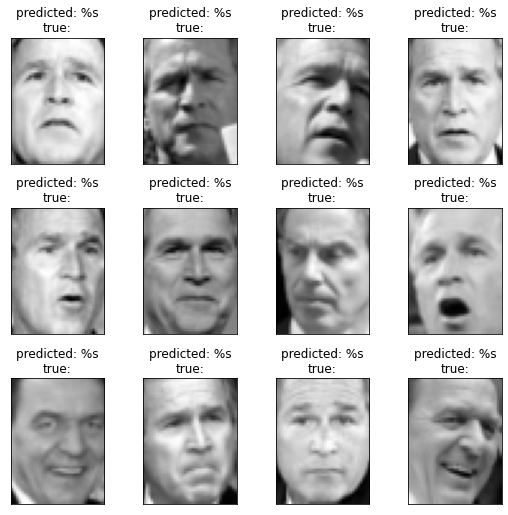

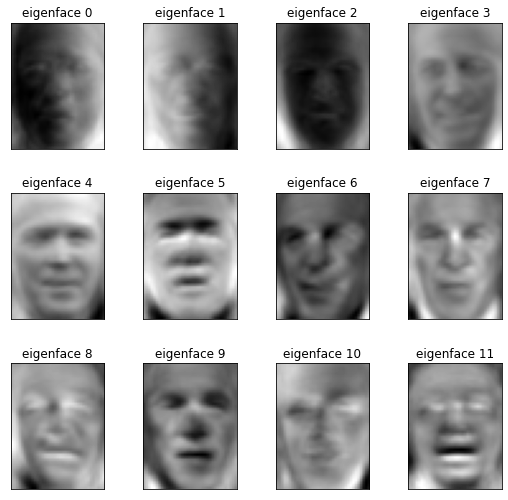

In [9]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d"%n_samples)
print("n_features: %d"%n_features)
print("n_classes: %d"%n_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_components = 150
print("Extracting the top %d eigenfaces from %d faces"%(n_components, X_train.shape[0]))
t0 =time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs"%(time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs"%(time() - t0))

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C':[1e3, 5e3, 1e4, 5e4, 1e5],
             "gamma":[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs"%(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:'

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
eigenface_titles = ["eigenface %d"%(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Random Projection

In [11]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
print(johnson_lindenstrauss_min_dim(n_samples=1e6, eps=0.5))
print(johnson_lindenstrauss_min_dim(n_samples=1e6, eps=[0.5, 0.1, 0.01]))
print(johnson_lindenstrauss_min_dim(n_samples=[1e4, 1e5, 1e6], eps=0.1))

663
[    663   11841 1112658]
[ 7894  9868 11841]


In [12]:
import sys
from time import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.fixes import parse_version
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

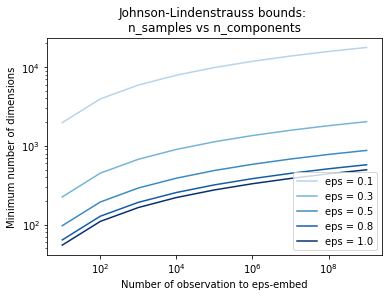

In [14]:
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)
plt.legend(["eps = %0.1f"%eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observation to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds: \nn_samples vs n_components")
plt.show()

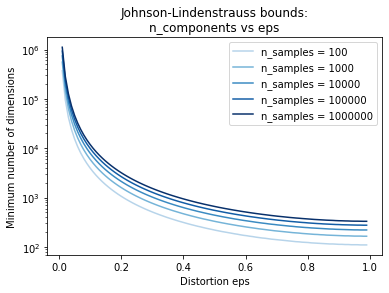

In [15]:
eps_range = np.linspace(0.01, 0.99, 100)
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))
plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)
plt.legend(["n_samples = %d"%n for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

Embedding 500 samples with dim 130107 using varius random projections
projected 500 samples from 130107 to 300 in 0.308s
random matrix with size: 1.293MB
Mean distances rate: 1.05 (0.17)
projected 500 samples from 130107 to 1000 in 0.975s
random matrix with size: 4.329MB
Mean distances rate: 1.05 (0.11)
projected 500 samples from 130107 to 10000 in 10.131s
random matrix with size: 43.332MB
Mean distances rate: 1.03 (0.03)


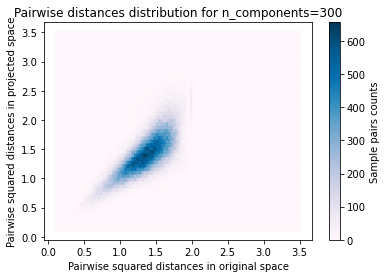

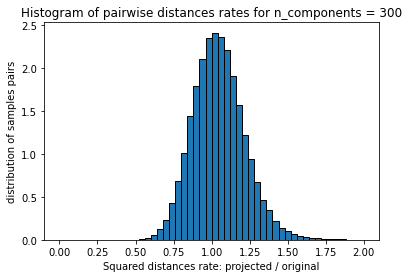

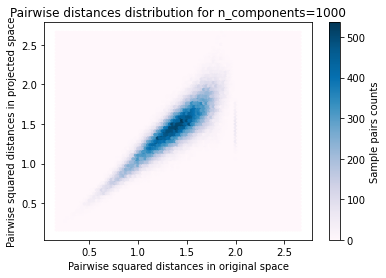

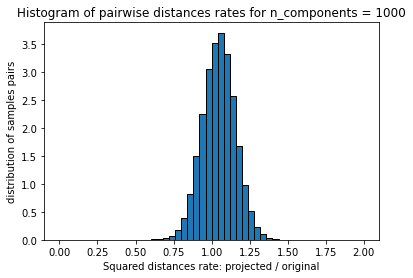

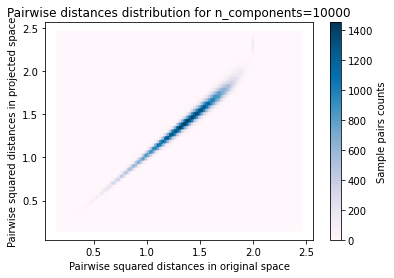

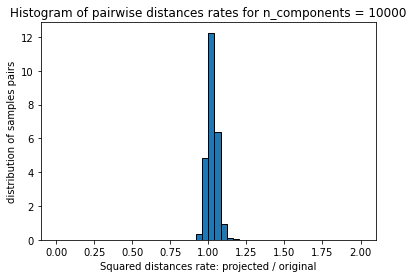

In [18]:
if '--use-digits-dataset' in sys.argv:
    data = load_digits().data[:500]
else:
    data = fetch_20newsgroups_vectorized().data[:500]

n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using varius random projections"%(n_samples, n_features))
n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(data, squared=True).ravel()
nonzero = dists != 0
dists = dists[nonzero]
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("projected %d samples from %d to %d in %0.3fs"%(n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("random matrix with size: %0.3fMB"%(n_bytes / 1e6))
    projected_dists = euclidean_distances(projected_data, squared=True).ravel()[nonzero]
    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu, extent=[min_dist, max_dist, min_dist, max_dist])
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d"%n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')
    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"%(np.mean(rates), np.std(rates)))
    plt.figure()
    plt.hist(rates, bins=50, range=(0, 2), edgecolor='k', **density_param)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("distribution of samples pairs")
    plt.title("Histogram of pairwise distances rates for n_components = %d"%n_components)
plt.show()

### Gaussian and Sparse Random Projection

In [19]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
rng = np.random.RandomState(42)
X = rng.rand(100, 10000)
transformer = GaussianRandomProjection(random_state=rng)
X_new = transformer.fit_transform(X)
X_new.shape

(100, 3947)

In [20]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(42)
X = rng.rand(100, 10000)
transformer = SparseRandomProjection(random_state=rng)
X_new = transformer.fit_transform(X)
print(X_new.shape)
np.mean(transformer.components_ != 0)

(100, 3947)


0.010009070179883443

## Feature Agglomeration

In [21]:
import numpy as np
from sklearn import datasets, cluster
digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
agglo = cluster.FeatureAgglomeration(n_clusters=32)
agglo.fit(X)
X_reduced = agglo.transform(X)
X_reduced.shape

(1797, 32)

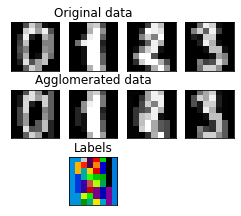

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from sklearn.feature_extraction.image import grid_to_graph
digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
connectivity = grid_to_graph(*images[0].shape)
agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32)
agglo.fit(X)
X_reduced = agglo.transform(X)
X_restored = agglo.inverse_transform(X_reduced)
images_restored = np.reshape(X_restored, images.shape)
plt.figure(1, figsize=(4, 3.5))
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    if i == 1:
        plt.title("Original data")
    plt.subplot(3, 4, 4 + i + 1)
    plt.imshow(images_restored[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    if i == 1:
        plt.title("Agglomerated data")
    plt.xticks(())
    plt.yticks(())
plt.subplot(3, 4, 10)
plt.imshow(np.reshape(agglo.labels_, images[0].shape), interpolation='nearest', cmap=plt.cm.nipy_spectral)
plt.xticks(())
plt.yticks(())
plt.title('Labels')
plt.show()

# Kernel Approximation

In [1]:
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem
X, y = datasets.load_digits(n_class=9, return_X_y=True)
data = X/16
clf = svm.LinearSVC()
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)
data_transformed = feature_map_nystroem.fit_transform(data)
clf.fit(data_transformed, y)
clf.score(data_transformed, y)

0.9987631416202845

In [5]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)
clf = SGDClassifier(max_iter=5, tol=1e-3)
clf.fit(X_features, y)
clf.score(X_features, y)

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


1.0

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA

# The digits dataset
digits = datasets.load_digits(n_class=9)

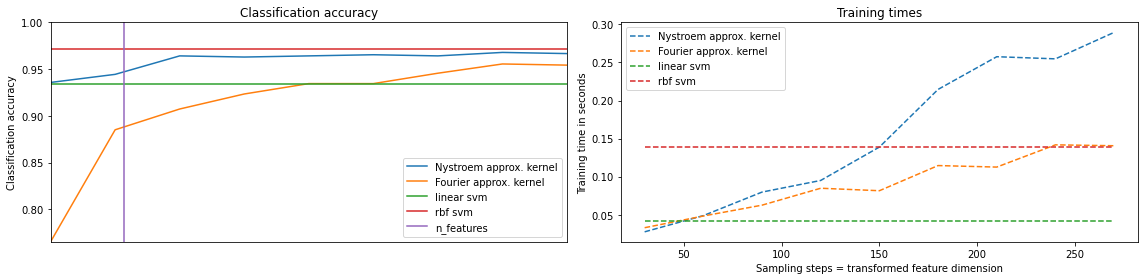

In [8]:
n_samples = len(digits.data)
data = digits.data / 16.
data -= data.mean(axis=0)

# We learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])
# data_test = scaler.transform(data_test)

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("svm", svm.LinearSVC())])

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()
plt.show()

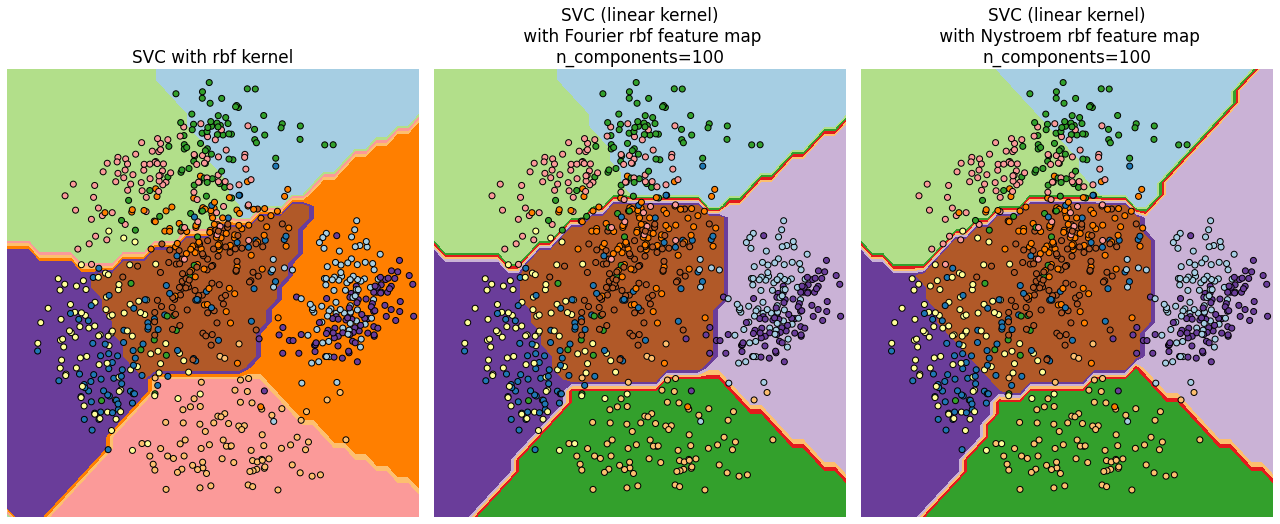

In [9]:
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({'font.size': 14})
# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm,
                         fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=targets_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler
X, y = load_digits(return_X_y=True)
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(X, y)
clf = SGDClassifier(max_iter=5, random_state=0, tol=1e-3)
clf.fit(X_transformed, y)
clf.score(X_transformed, y)

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


0.9499165275459098

In [16]:
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.linear_model import SGDClassifier
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]
chi_2_feature = SkewedChi2Sampler(skewedness=0.01, n_components=10, random_state=0)
X_features = chi_2_feature.fit_transform(X, y)
clf = SGDClassifier(max_iter=10, tol=1e-3)
clf.fit(X_features, y)
clf.score(X_features, y)

1.0

# Pairwise metrics, Affinites and Kernels

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
X = np.array([[2, 3], [3, 5], [5, 8]])
Y = np.array([[1, 0], [2, 1]])
print(pairwise_distances(X, Y, metric='manhattan'))
print(pairwise_distances(X, metric='manhattan'))
print(pairwise_kernels(X, Y, metric='linear'))

[[ 4.  2.]
 [ 7.  5.]
 [12. 10.]]
[[0. 3. 8.]
 [3. 0. 5.]
 [8. 5. 0.]]
[[ 2.  7.]
 [ 3. 11.]
 [ 5. 18.]]


In [3]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel
X = [[0, 1], [1, 0], [.2, .8], [.7, .3]]
y = [0, 1, 0, 1]
k = chi2_kernel(X, gamma=.5)
print(k)
svm = SVC(kernel = 'precomputed').fit(k, y)
svm.predict(k)

[[1.         0.36787944 0.89483932 0.58364548]
 [0.36787944 1.         0.51341712 0.83822343]
 [0.89483932 0.51341712 1.         0.7768366 ]
 [0.58364548 0.83822343 0.7768366  1.        ]]


array([0, 1, 0, 1])

In [4]:
svm = SVC(kernel=chi2_kernel).fit(X, y)
svm.predict(X)

array([0, 1, 0, 1])

# Label Binarization

In [5]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit([1, 2, 6, 4, 2])
print(lb.classes_)
lb.transform([1, 6])

[1 2 4 6]


array([[1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=int32)

In [6]:
lb = preprocessing.LabelBinarizer()
lb.fit_transform(['yes', 'no', 'no', 'yes'])

array([[1],
       [0],
       [0],
       [1]], dtype=int32)

In [7]:
import numpy as np
lb.fit(np.array([[0, 1, 1], [1, 0, 0]]))
print(lb.classes_)
lb.transform([0, 1, 2, 1])

[0 1 2]


array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int32)

# Multi Label Binarizer

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit_transform([(1, 2), (3,)])

array([[1, 1, 0],
       [0, 0, 1]])

In [10]:
mlb.classes_

array([1, 2, 3])

In [11]:
mlb.fit_transform([{'sci-fi', 'thriller'}, {'comedy'}])

array([[0, 1, 1],
       [1, 0, 0]])

In [12]:
list(mlb.classes_)

['comedy', 'sci-fi', 'thriller']

In [13]:
mlb = MultiLabelBinarizer()
mlb.fit(['sci-fi', 'thriller', 'comedy'])
mlb.classes_

array(['-', 'c', 'd', 'e', 'f', 'h', 'i', 'l', 'm', 'o', 'r', 's', 't',
       'y'], dtype=object)

In [14]:
mlb = MultiLabelBinarizer()
mlb.fit([['sci-fi', 'thiriller', 'comedy']])
mlb.classes_

array(['comedy', 'sci-fi', 'thiriller'], dtype=object)

In [15]:
y = [[2, 3, 4], [2], [0, 1, 3], [0, 1, 2, 3, 4], [0, 1, 2]]
MultiLabelBinarizer().fit_transform(y)

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0]])

# Label Encoder 

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1, 2, 2, 6])
le.classes_

array([1, 2, 6])

In [17]:
le.transform([1, 1, 2, 6])

array([0, 0, 1, 2], dtype=int32)

In [18]:
le.inverse_transform([0, 0, 1, 2])

array([1, 1, 2, 6])

In [19]:
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])

LabelEncoder()

In [20]:
list(le.classes_)

['amsterdam', 'paris', 'tokyo']

In [22]:
le.transform(["tokyo", "tokyo", "paris"])

array([2, 2, 1], dtype=int32)

In [23]:
list(le.inverse_transform([2, 2, 1]))

['tokyo', 'tokyo', 'paris']

# Example

In [1]:
from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

In [3]:
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

In [6]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               alternate_sign=False)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(max_iter=5),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [('{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 878 documents (108 positive)
                 SGD classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.822 in 2.93s (  328 docs/s)
          Perceptron classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.855 in 2.94s (  326 docs/s)
      NB Multinomial classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.877 in 2.99s (  321 docs/s)
  Passive-Aggressive classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.933 in 3.00s (  321 docs/s)


Mini batch size 1000
Mini batch size 1000
Mini batch size 1000
                 SGD classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.932 in 7.89s (  495 docs/s)
          Perceptron classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.936 in 7.89s (  495 docs/s)
      NB Multinomi

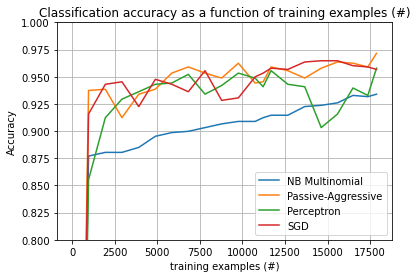

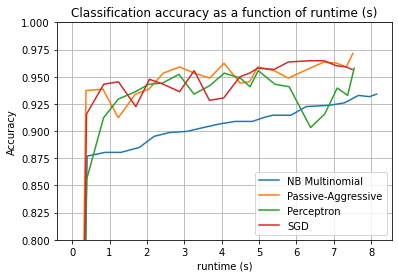

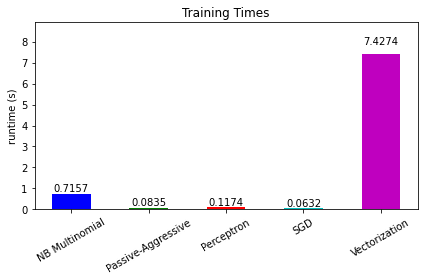

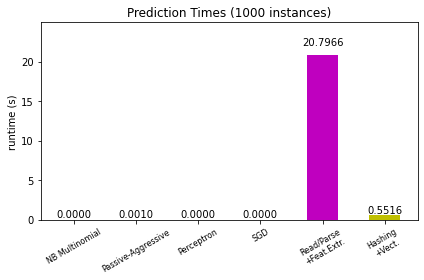

In [5]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)


rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats['total_fit_time']
               for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()

In [1]:
from sklearn import svm
from sklearn import datasets 
clf = svm.SVC()
X, y = datasets.load_iris(return_X_y = True)
clf.fit(X, y)

SVC()

In [17]:
from joblib import dump, load
import joblib
joblib.dump(clf, 'classifier.pkl')

['classifier.pkl']

In [18]:
clfs = joblib.load("classifier.pkl")
clfs.predict(X[0:1])

array([0])

array([[5.1, 3.5, 1.4, 0.2]])